<a href="https://colab.research.google.com/github/KareemEzzaldin/Sentiment-Analysis-on-Social-Media-Data-NLP/blob/main/Sentiment_Analysis_on_Social_Media_Data_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded Reddit_Data.csv rows=37249 text_col=clean_comment label_col=category
Loaded Twitter_Data.csv rows=147473 text_col=clean_text label_col=category
Unique labels found: ['1.0' '-1.0' '0.0']
Label distribution: {'1.0': 80982, '0.0': 62688, '-1.0': 40531}
Rows 184201
Sources {'twitter': np.int64(147412), 'reddit': np.int64(36789)}
Class counts {'1.0': np.int64(80982), '0.0': np.int64(62688), '-1.0': np.int64(40531)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model logreg best_cv_f1=0.9226 params={'clf__C': 2.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model linsvc best_cv_f1=0.9375 params={'clf__C': 1.0, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Model cnb best_cv_f1=0.7540 params={'clf__alpha': 1.0, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Selected model linsvc
CV {'best_cv_f1': np.float64(0.9375358821116879), 'best_params': {'clf__C': 1.0, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}}
{
  "accuracy": 0.9469,
  "per_class": {
    "-1.0": {
      "precision": 0.9049,
      "recall": 0.9013,
      "f1": 0.9031
    },
    "0.0": {
      "precision": 0.963,
      "recall": 0.9806,
      "f1": 0.9717
    },
    "1.0": {
      "precision": 0.9553,
      "recall": 0.9437,
      "f1": 0.9495
    }
  }
}

Classification report

              precision    recall  f1-score   support

        -1.0     0.9049    0.9013    0.9031      8106
         0.0     0.9630    0.9806    0.9717     12538
         1.0     0.9553    0.9437    0.9495     16197

    accuracy                         0.9469     36841
   macro avg     0.9411    0.9419    0.9414     36841
weighted avg     0.9468    0.9469    0.9468     36841



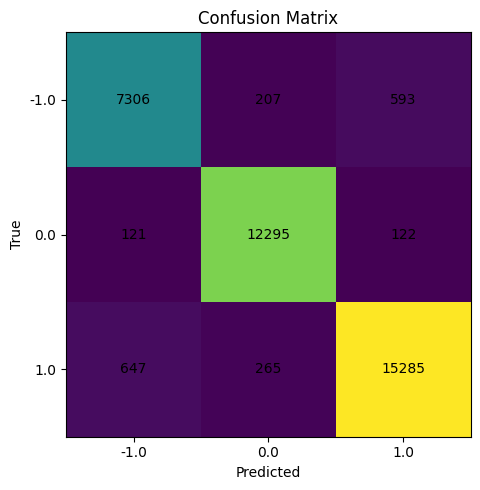


Top features per class
-1.0 hate, worst, stupid, pathetic, disgusting, poor, bloody, idiots, bad, insulting, failed, wrong, fake, sick, moron, dangerous, evil, morons, base, idiot, corrupt, crap, terrible, rank, afraid
0.0 coalitionkhichdi, hardships, samriti, rajkumar, uniforms, alpha, squads, impractical, sect, pitchforks, earnings, shapath, veneer, rajinikanth, sucked, evaluated, ―, smiriti, crow, scandalous, siphoned, soaps, progressed, vacant, shames
1.0 best, great, more, proud, good, lol, own, many, win, successfully, better, kind, most, love, honest, strong, top, first, free, huge, successful, excellent, right, full, latest
Install lime to enable local explanations: pip install lime
Saved artifacts to artifacts


In [ ]:
import os
import re
import json
import joblib
import string
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt

try:
    from lime.lime_text import LimeTextExplainer
    LIME_AVAILABLE = True
except Exception:
    LIME_AVAILABLE = False


@dataclass
class Config:
    random_state: int = 42
    test_size: float = 0.2
    n_jobs: int = -1
    max_features: int = 100_000
    artifacts_dir: str = "artifacts"

CFG = Config()


TEXT_COL_CANDIDATES = [
    "text", "Text", "clean_text", "tweet", "content", "body", "message", "clean_comment"
]
LABEL_COL_CANDIDATES = [
    "label", "Label", "sentiment", "Sentiment", "target", "polarity", "category"
]


def detect_columns(df: pd.DataFrame) -> Tuple[str, str]:
    text_col = None
    label_col = None
    for c in TEXT_COL_CANDIDATES:
        if c in df.columns:
            text_col = c
            break
    for c in LABEL_COL_CANDIDATES:
        if c in df.columns:
            label_col = c
            break
    if text_col is None:
        obj_cols = [c for c in df.columns if df[c].dtype == "O"]
        if obj_cols:
            text_col = obj_cols[0]
    if label_col is None:
        non_obj = [c for c in df.columns if df[c].dtype != "O"]
        if non_obj:
            label_col = non_obj[-1]
    if text_col is None or label_col is None:
        raise ValueError("Could not infer text/label columns. Set them explicitly.")
    return text_col, label_col


URL_RE = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)
MENTION_RE = re.compile(r"@[A-Za-z0-9_]+")
HASHTAG_RE = re.compile(r"#[A-Za-z0-9_]+")
EMOJI_RE = re.compile(
    "[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]",
    flags=re.UNICODE,
)
PUNCT_TABLE = str.maketrans("", "", string.punctuation)


def basic_clean(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = MENTION_RE.sub(" ", s)
    s = HASHTAG_RE.sub(" ", s)
    s = EMOJI_RE.sub(" ", s)
    s = s.translate(PUNCT_TABLE)
    s = re.sub(r"\s+", " ", s).strip()
    return s



def load_csv_safe(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        return pd.DataFrame()
    try:
        return pd.read_csv(path)
    except Exception:
        for enc in ["utf-8", "ISO-8859-1", "latin1", "cp1252"]:
            try:
                return pd.read_csv(path, encoding=enc)
            except Exception:
                continue
    return pd.DataFrame()


def load_datasets() -> pd.DataFrame:
    candidates = [
        ("reddit", "/mnt/data/Reddit_Data.csv"),
        ("twitter", "/mnt/data/Twitter_Data.csv"),
        ("reddit", "Reddit_Data.csv"),
        ("twitter", "Twitter_Data.csv"),
    ]
    frames = []
    for source, path in candidates:
        df = load_csv_safe(path)
        if not df.empty:
            tcol, lcol = detect_columns(df)
            tmp = df[[tcol, lcol]].copy()
            tmp.columns = ["text", "label"]
            tmp["source"] = source
            frames.append(tmp)
            print(f"Loaded {path} rows={len(tmp)} text_col={tcol} label_col={lcol}")
    if not frames:
        raise FileNotFoundError("No dataset found.")

    data = pd.concat(frames, axis=0, ignore_index=True)

    data.dropna(subset=["text", "label"], inplace=True)
    data.drop_duplicates(subset=["text", "label"], inplace=True)

    data["clean"] = data["text"].map(basic_clean)
    data = data[data["clean"].str.len() > 0]

    data["label"] = data["label"].astype(str).str.strip().str.lower()

    print("Unique labels found:", data["label"].unique())
    print("Label distribution:", data["label"].value_counts().to_dict())

    return data


def identity_func(x):
    return x


def build_pipelines() -> Dict[str, Pipeline]:
    common_vectorizer = TfidfVectorizer(
        preprocessor=identity_func,
        tokenizer=str.split,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.98,
        max_features=CFG.max_features,
    )

    models = {
        "logreg": LogisticRegression(max_iter=200, class_weight="balanced"),
        "linsvc": LinearSVC(class_weight="balanced"),
        "cnb": ComplementNB(),
    }

    pipes = {}
    for name, clf in models.items():
        pipes[name] = Pipeline([
            ("tfidf", common_vectorizer),
            ("clf", clf),
        ])
    return pipes


def build_param_grids() -> Dict[str, Dict[str, List]]:
    return {
        "logreg": {
            "tfidf__ngram_range": [(1, 1), (1, 2)],
            "tfidf__min_df": [2, 5],
            "clf__C": [0.5, 1.0, 2.0],
            "clf__penalty": ["l2"],
            "clf__solver": ["liblinear", "lbfgs"],
        },
        "linsvc": {
            "tfidf__ngram_range": [(1, 1), (1, 2)],
            "tfidf__min_df": [2, 5],
            "clf__C": [0.5, 1.0, 2.0],
        },
        "cnb": {
            "tfidf__ngram_range": [(1, 1), (1, 2)],
            "tfidf__min_df": [2, 5],
            "clf__alpha": [0.1, 0.5, 1.0],
        },
    }


def train_and_select(X_train, y_train) -> Tuple[str, Pipeline, Dict]:
    pipes = build_pipelines()
    grids = build_param_grids()
    best_name = None
    best_model = None
    best_score = -np.inf
    best_cv = {}

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.random_state)

    for name, pipe in pipes.items():
        param_grid = grids[name]
        gs = GridSearchCV(
            pipe,
            param_grid=param_grid,
            scoring="f1_macro",
            cv=skf,
            n_jobs=CFG.n_jobs,
            verbose=1,
        )
        gs.fit(X_train, y_train)
        print(f"Model {name} best_cv_f1={gs.best_score_:.4f} params={gs.best_params_}")
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_name = name
            best_model = gs.best_estimator_
            best_cv = gs.best_params_

    return best_name, best_model, {"best_cv_f1": best_score, "best_params": best_cv}


def evaluate(model: Pipeline, X_test, y_test, labels: List[str]):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, labels=labels, average=None)
    print(json.dumps({
        "accuracy": round(float(acc), 4),
        "per_class": {
            labels[i]: {
                "precision": round(float(prec[i]), 4),
                "recall": round(float(rec[i]), 4),
                "f1": round(float(f1[i]), 4),
            } for i in range(len(labels))
        }
    }, indent=2))

    print("\nClassification report\n")
    print(classification_report(y_test, preds, digits=4))

    cm = confusion_matrix(y_test, preds, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(cm, interpolation='nearest')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')
    fig.tight_layout()
    plt.show()


def top_features(model: Pipeline, labels: List[str], k: int = 20) -> Dict[str, List[Tuple[str, float]]]:
    out = {}
    vec: TfidfVectorizer = model.named_steps['tfidf']
    feature_names = np.array(vec.get_feature_names_out())

    clf = model.named_steps['clf']

    if hasattr(clf, 'coef_'):
        coefs = clf.coef_
        for idx, label in enumerate(labels):
            topk = np.argsort(coefs[idx])[-k:][::-1]
            out[label] = list(zip(feature_names[topk], coefs[idx, topk]))
    elif hasattr(clf, 'feature_log_prob_'):
        for idx, label in enumerate(labels):
            scores = clf.feature_log_prob_[idx]
            topk = np.argsort(scores)[-k:][::-1]
            out[label] = list(zip(feature_names[topk], scores[topk]))
    return out


def explain_with_lime(model: Pipeline, samples: List[str], labels: List[str], num_features: int = 10):
    if not LIME_AVAILABLE:
        print("Install lime to enable local explanations: pip install lime")
        return
    explainer = LimeTextExplainer(class_names=labels)
    for s in samples:
        exp = explainer.explain_instance(s, model.predict_proba, num_features=num_features)
        print("Sample:", s)
        print(exp.as_list())


def save_artifacts(model: Pipeline, label_list: List[str]):
    os.makedirs(CFG.artifacts_dir, exist_ok=True)
    joblib.dump(model, os.path.join(CFG.artifacts_dir, 'sentiment_model.joblib'))
    with open(os.path.join(CFG.artifacts_dir, 'labels.json'), 'w') as f:
        json.dump(label_list, f)
    print(f"Saved artifacts to {CFG.artifacts_dir}")


def load_artifacts() -> Tuple[Pipeline, List[str]]:
    model = joblib.load(os.path.join(CFG.artifacts_dir, 'sentiment_model.joblib'))
    with open(os.path.join(CFG.artifacts_dir, 'labels.json')) as f:
        labels = json.load(f)
    return model, labels


def predict(texts: List[str]) -> List[Dict]:
    model, labels = load_artifacts()
    clean_texts = [basic_clean(t) for t in texts]
    probs = None
    if hasattr(model.named_steps['clf'], 'predict_proba'):
        probs = model.predict_proba(clean_texts)
    preds = model.predict(clean_texts)
    results = []
    for i, t in enumerate(texts):
        item = {"text": t, "label": preds[i]}
        if probs is not None:
            p = probs[i]
            item["probs"] = {labels[j]: float(p[j]) for j in range(len(labels))}
        results.append(item)
    return results


def main():
    data = load_datasets()

    print("Rows", len(data))
    print("Sources", dict(data['source'].value_counts()))
    print("Class counts", dict(data['label'].value_counts()))

    X = data['clean'].values
    y = data['label'].values

    labels = sorted(data['label'].unique().tolist())

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=CFG.test_size, random_state=CFG.random_state, stratify=y
    )

    model_name, model, cv_info = train_and_select(X_train, y_train)
    print("Selected model", model_name)
    print("CV", cv_info)

    evaluate(model, X_test, y_test, labels)

    feats = top_features(model, labels, k=25)
    print("\nTop features per class")
    for label, items in feats.items():
        print(label, ", ".join([f"{w}" for w,_ in items]))

    samples = data['clean'].sample(n=min(3, len(data)), random_state=CFG.random_state).tolist()
    explain_with_lime(model, samples, labels)

    save_artifacts(model, labels)


if __name__ == "__main__":
    main()
